In [ ]:
#%%

#
#  60/40 portfolio on raw proxies
#  SPY for the stocks
#  AGG for the bonds
#

import warnings
warnings.filterwarnings("ignore")
def action_with_warnings():
    warnings.warn("should not appear")
with warnings.catch_warnings(record=True):
    action_with_warnings()
import norgatedata
import quantstats        as qs
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt

[2024-04-16 05:08:37.378833] INFO: Norgate Data: NorgateData package v1.0.74: Init complete


In [ ]:
#%%

# Preparing data using Norgate

# Stocks
spy_df = norgatedata.price_timeseries(
    "SPY",
    stock_price_adjustment_setting = norgatedata.StockPriceAdjustmentType.TOTALRETURN,
    padding_setting                = norgatedata.PaddingType.NONE,
    start_date                     = "1990-01-01",
    timeseriesformat               = 'pandas-dataframe',
)

df = pd.DataFrame(index=spy_df.index)
df['SPY'] = spy_df['Close']

# Bonds
agg_df = norgatedata.price_timeseries(
    "AGG",
    stock_price_adjustment_setting = norgatedata.StockPriceAdjustmentType.TOTALRETURN,
    padding_setting                = norgatedata.PaddingType.NONE,
    start_date                     = "1990-01-01",
    timeseriesformat               = 'pandas-dataframe',
)

df['AGG'] = agg_df['Close']

df

,SPY,AGG
Date,,
1993-01-29,24.707020,NaN
1993-02-01,24.847401,NaN
1993-02-02,24.917591,NaN
1993-02-03,25.128162,NaN
1993-02-04,25.268543,NaN
...,...,...
2024-04-09,519.320007,96.919998
2024-04-10,514.119995,95.760002
2024-04-11,518.000000,95.779999


In [ ]:
#%%

df.dropna(inplace=True)

df

,SPY,AGG
Date,,
2003-09-26,67.640236,54.015850
2003-09-29,68.303444,53.868225
2003-09-30,67.640236,54.147659
2003-10-01,69.081696,54.121300
2003-10-02,69.332092,54.036942
...,...,...
2024-04-09,519.320007,96.919998
2024-04-10,514.119995,95.760002
2024-04-11,518.000000,95.779999


<Axes: xlabel='Date'>

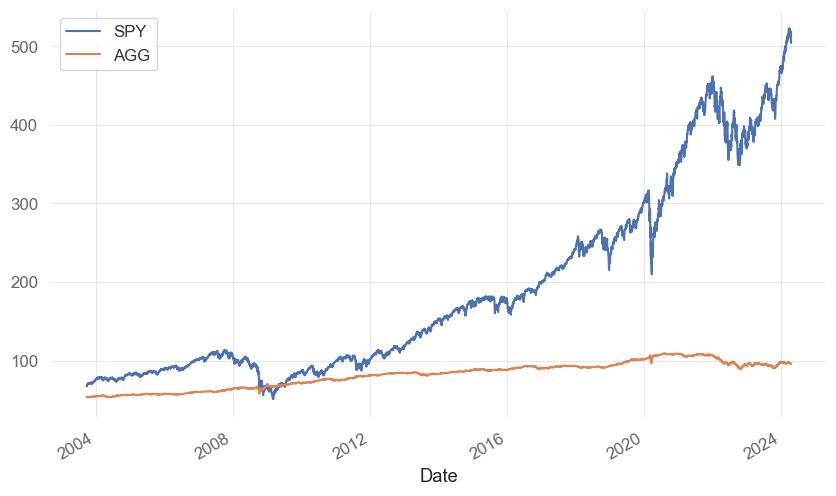

In [ ]:
#%%

df[['SPY', 'AGG']].plot()

<Axes: xlabel='Date'>

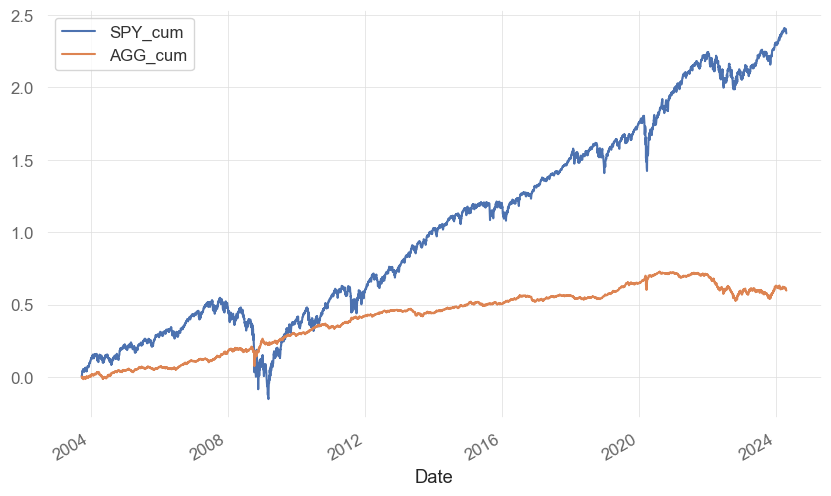

In [ ]:
#%%

df['SPY_ret'] = df['SPY'    ].pct_change()
df['AGG_ret'] = df['AGG'    ].pct_change()
df['SPY_cum'] = df['SPY_ret'].cumsum()
df['AGG_cum'] = df['AGG_ret'].cumsum()

df[['SPY_cum', 'AGG_cum']].plot()

In [ ]:
#%%

# 2 BPS for trading cost proxy using Interactive Brokers fee model, very optimistic
rebalancing_cost        = 0.02/100.0
rebalancing_cost_log    = np.log(1-rebalancing_cost)

previous_rebalance_date = None
rebalance_frequency     = 'W-MON' # Weekly rebalance
stock_weight            = 0.6
bond_weight             = 0.4
portfolio_dates         = []
portfolio_returns       = []

for date, group in df.groupby(pd.Grouper(freq=rebalance_frequency)):
    group_df = group.copy()
    group_df['SPY_freq_cum'] = group_df['SPY_ret'].cumsum()
    group_df['AGG_freq_cum'] = group_df['AGG_ret'].cumsum()
    return_at_rebalance = stock_weight * group_df.iloc[-1]['SPY_freq_cum'] + bond_weight * group_df.iloc[-1]['AGG_freq_cum']
    portfolio_dates.append(date)
    portfolio_returns.append(return_at_rebalance)

portfolio_df = pd.DataFrame(index=portfolio_dates)
portfolio_df.index = pd.to_datetime(portfolio_df.index)
portfolio_df['ret'             ] = portfolio_returns
portfolio_df['log_ret'         ] = (1+portfolio_df['ret']).apply(np.log)
portfolio_df['adjusted_log_ret'] = portfolio_df['log_ret'] + rebalancing_cost_log
portfolio_df['cum'             ] = portfolio_df['log_ret'].cumsum().apply(np.exp)
portfolio_df['adjusted_cum'    ] = portfolio_df['adjusted_log_ret'].cumsum().apply(np.exp)
portfolio_df['adjusted_ret'    ] = portfolio_df['adjusted_cum'].pct_change()

portfolio_df

,ret,log_ret,adjusted_log_ret,cum,adjusted_cum,adjusted_ret
2003-09-29,0.004790,0.004778,0.004578,1.004790,1.004589,NaN
2003-10-06,0.016326,0.016195,0.015995,1.021194,1.020786,0.016123
2003-10-13,0.004632,0.004621,0.004421,1.025924,1.025309,0.004431
2003-10-20,-0.000312,-0.000312,-0.000512,1.025604,1.024784,-0.000512
2003-10-27,-0.005290,-0.005304,-0.005504,1.020179,1.019159,-0.005489
...,...,...,...,...,...,...
2024-03-18,-0.000971,-0.000972,-0.001172,4.721192,3.812328,-0.001171
2024-03-25,0.010707,0.010650,0.010450,4.771742,3.852375,0.010505
2024-04-01,0.001098,0.001097,0.000897,4.776981,3.855834,0.000898
2024-04-08,-0.005316,-0.005330,-0.005530,4.751586,3.834569,-0.005515


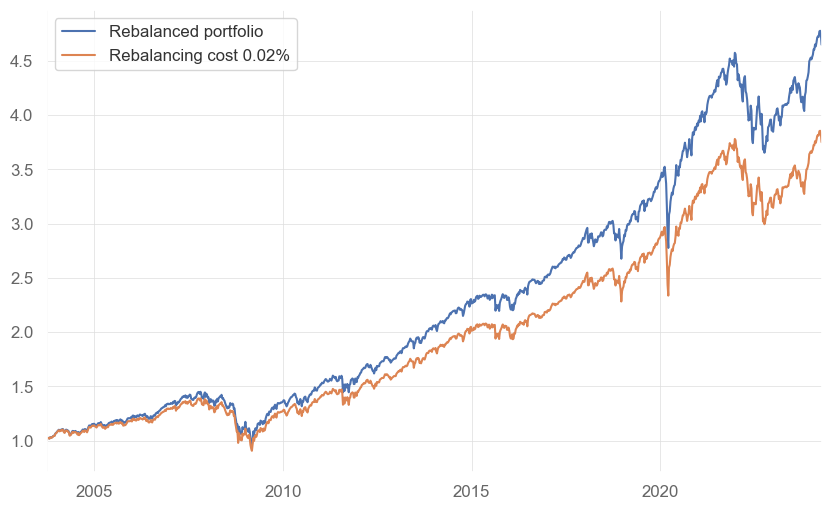

In [ ]:
#%%

portfolio_df[['cum', 'adjusted_cum']].plot()
plt.legend(['Rebalanced portfolio', f"Rebalancing cost {round(rebalancing_cost*100,2)}%"])

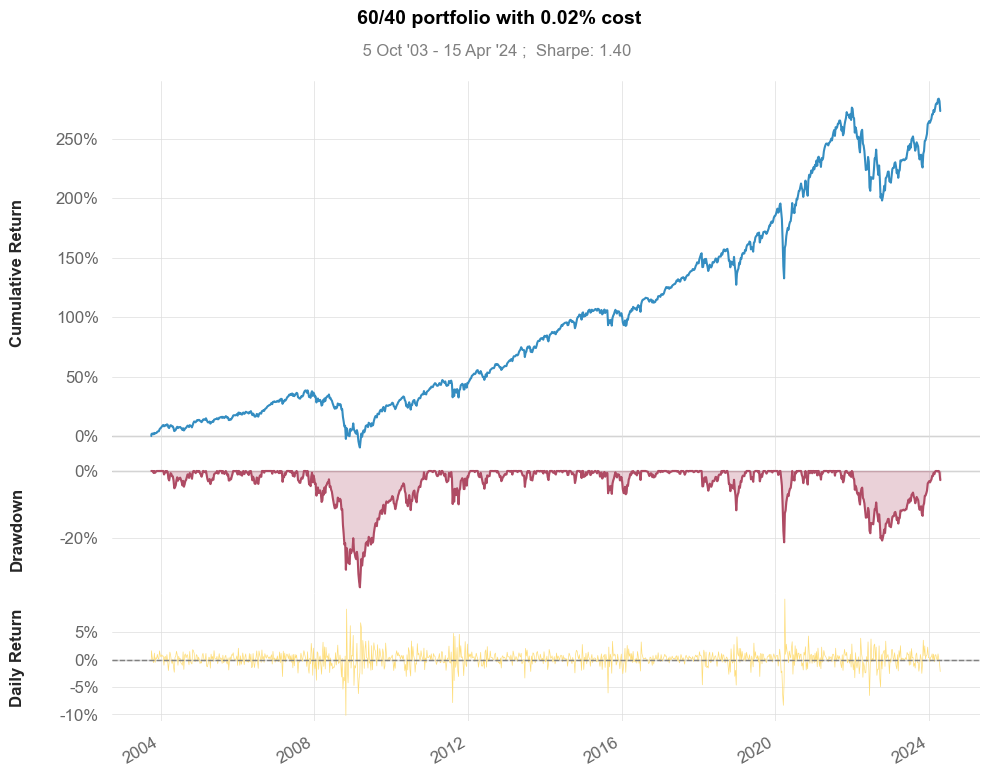

In [ ]:
#%%

qs.plots.snapshot(portfolio_df['adjusted_ret'], title=f"60/40 portfolio with {round(rebalancing_cost*100,2)}% cost", show=True);

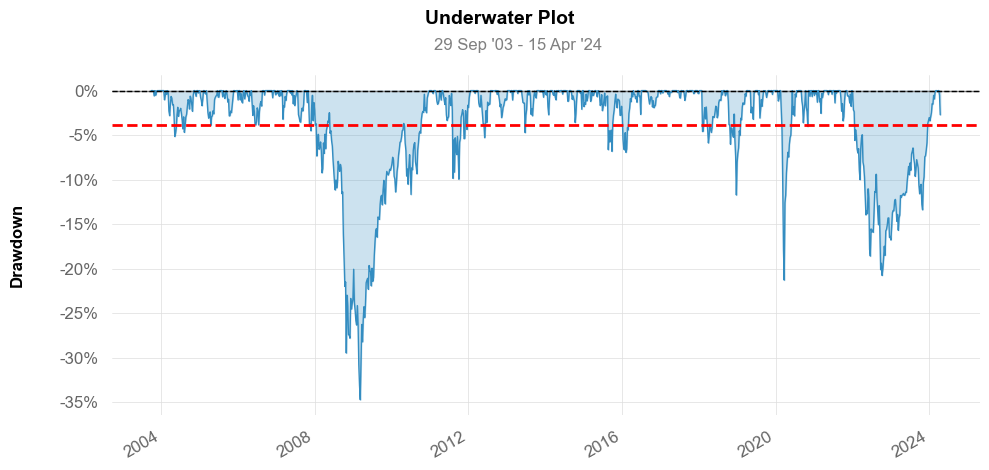

In [ ]:
#%%

qs.plots.drawdown(portfolio_df['adjusted_ret'])

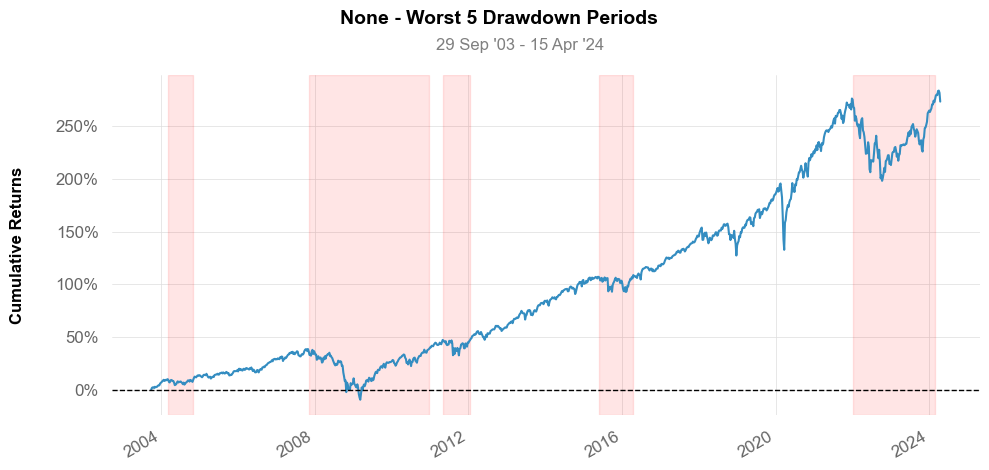

In [ ]:
#%%

qs.plots.drawdowns_periods(portfolio_df['adjusted_ret'])

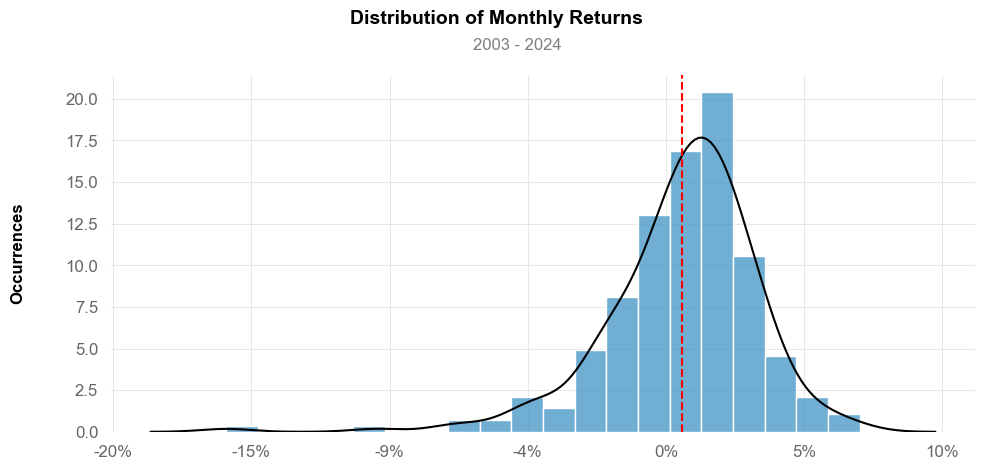

In [ ]:
#%%

qs.plots.histogram(portfolio_df['adjusted_ret'])

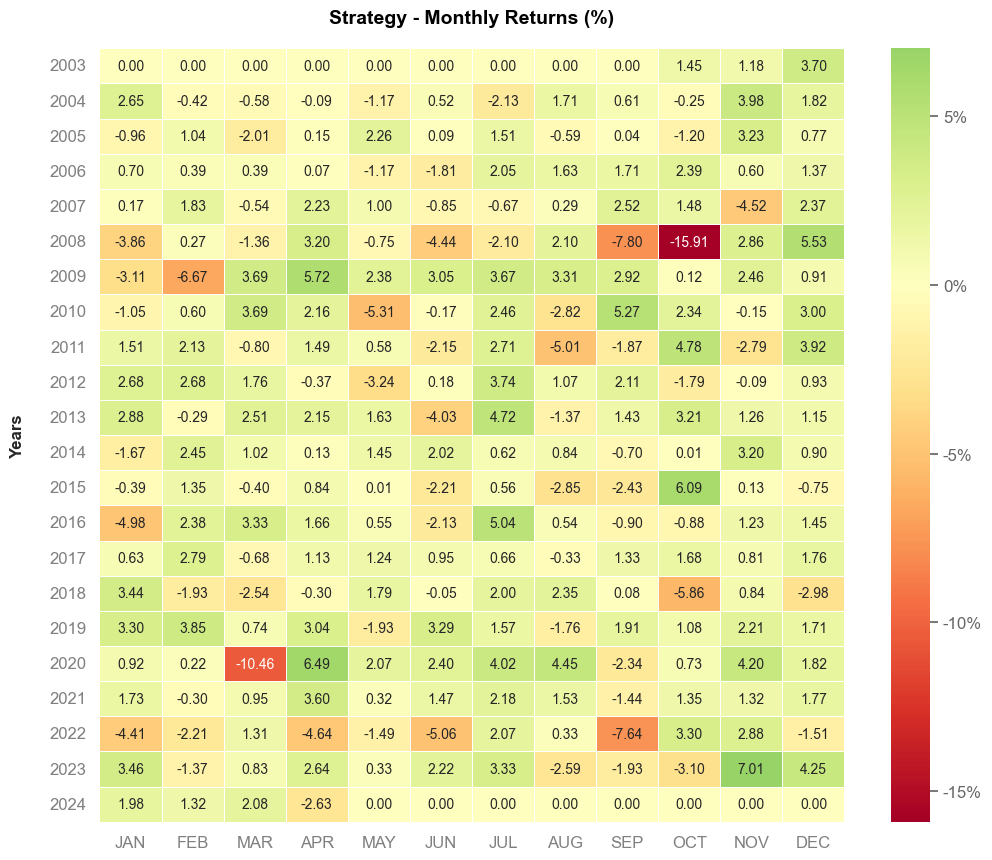

In [ ]:
#%%

qs.plots.monthly_heatmap(portfolio_df['adjusted_ret'])

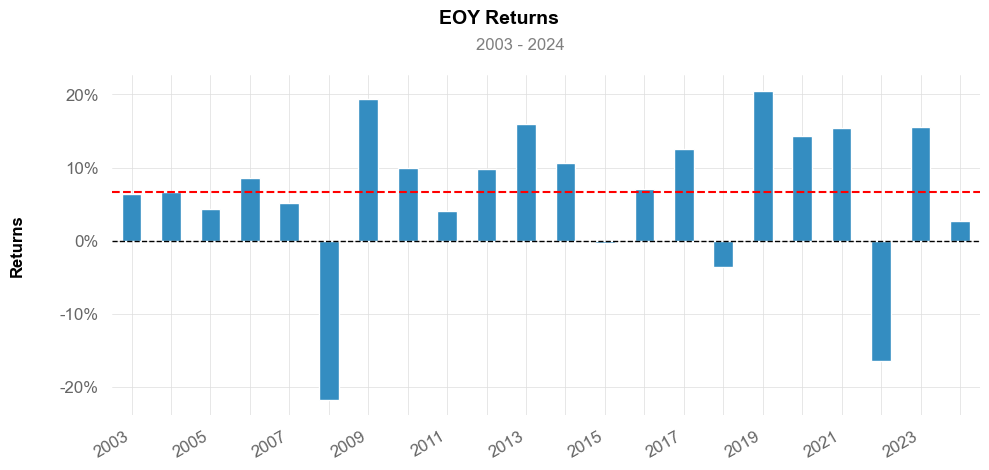

In [ ]:
#%%

qs.plots.yearly_returns(portfolio_df['adjusted_ret'])

In [ ]:
#%%

qs.stats.sharpe(portfolio_df['adjusted_ret'])

1.4002673671573806

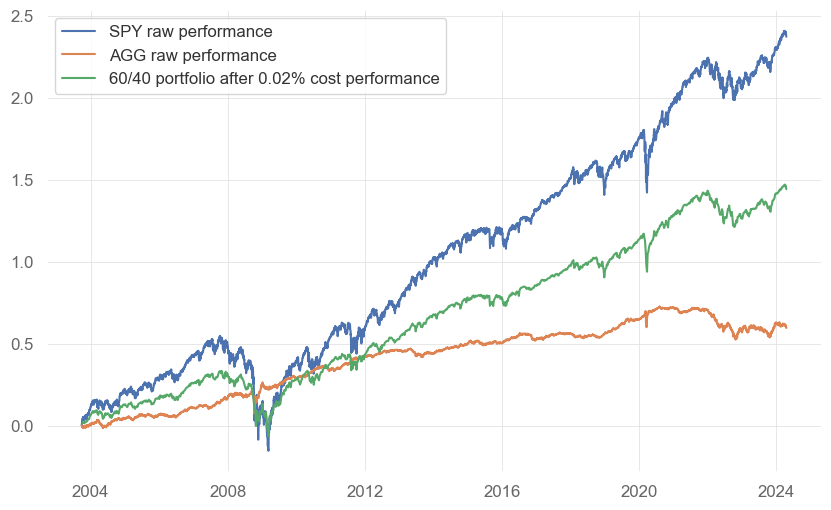

In [ ]:
#%%

plt.plot(df['SPY_cum'])
plt.plot(df['AGG_cum'])
plt.plot(portfolio_df['adjusted_ret'].cumsum())
plt.legend(['SPY raw performance', 'AGG raw performance', f"60/40 portfolio after {round(rebalancing_cost*100.0, 2)}% cost performance"])
plt.show()

                           Strategy
-------------------------  ----------
Start Period               2003-10-06
End Period                 2024-04-15
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          273.39%
CAGR﹪                     4.53%

Sharpe                     1.4
Prob. Sharpe Ratio         99.77%
Smart Sharpe               1.3
Sortino                    2.0
Smart Sortino              1.86
Sortino/√2                 1.42
Smart Sortino/√2           1.32
Omega                      1.3

Max Drawdown               -34.74%
Longest DD Days            1142
Volatility (ann.)          24.22%
Calmar                     0.13
Skew                       -0.31
Kurtosis                   8.61

Expected Daily %           0.12%
Expected Monthly %         0.53%
Expected Yearly %          6.17%
Kelly Criterion            13.72%
Risk of Ruin               0.0%
Daily Value-at-Risk        -2.37%
Expected Shortfall (cVaR)  -2.37%

Max Consecutive Wins       

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2007-11-05,2009-03-09,2010-12-20,1142,-34.744756,-30.790315
2,2020-02-24,2020-03-23,2020-06-01,99,-21.300411,-17.910989
3,2022-01-03,2022-10-10,2024-02-26,785,-20.775615,-20.015942
4,2018-10-08,2018-12-24,2019-03-25,169,-11.734993,-8.065556
5,2011-05-09,2011-10-03,2012-01-16,253,-9.959632,-9.864475


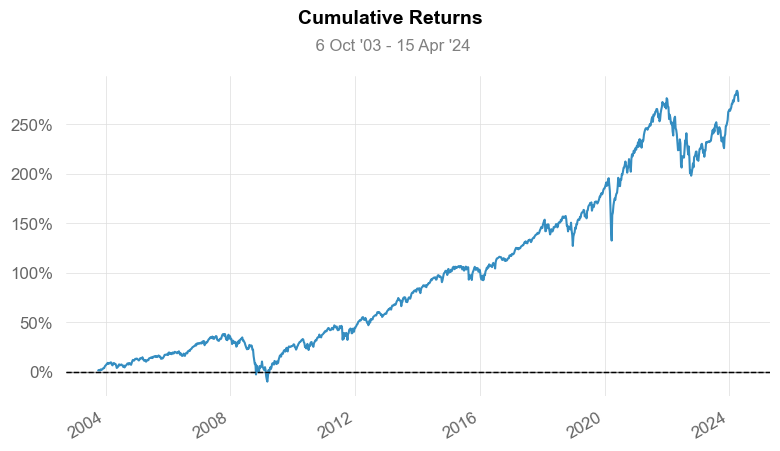

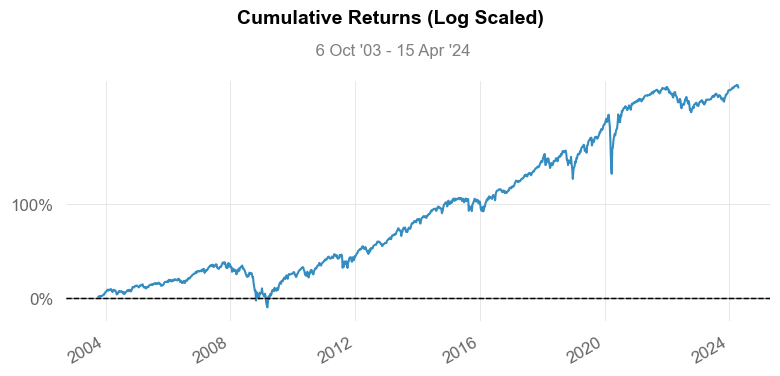

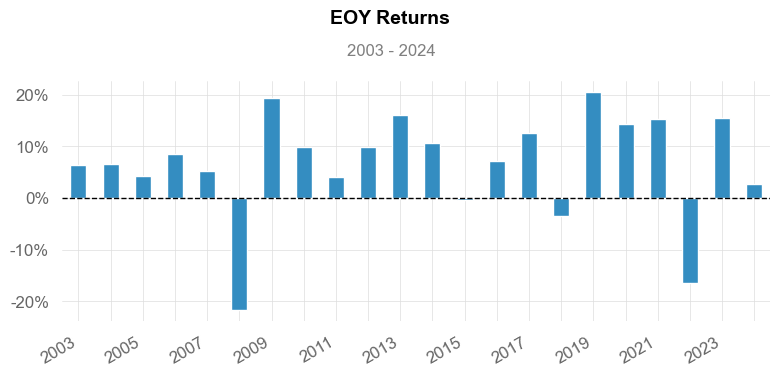

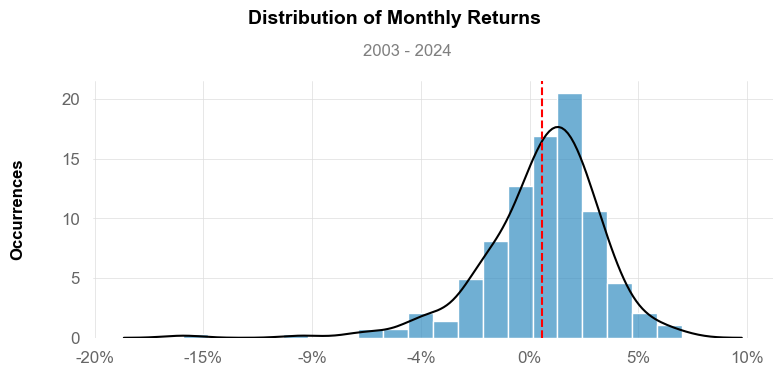

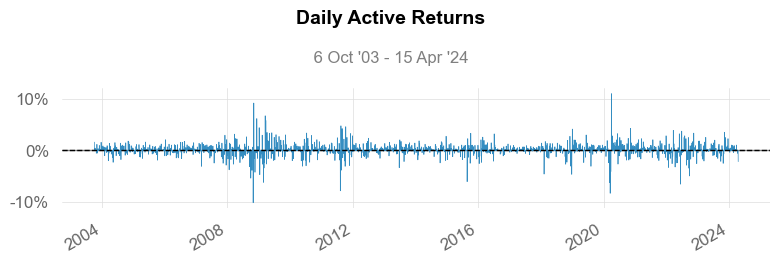

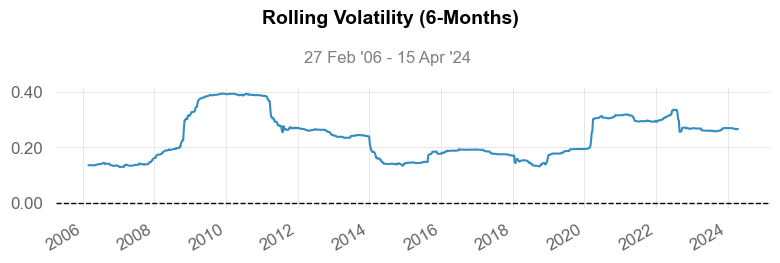

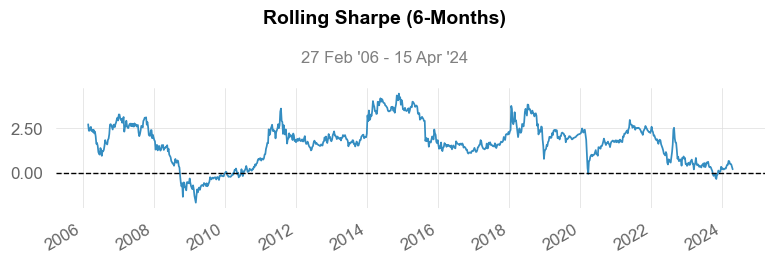

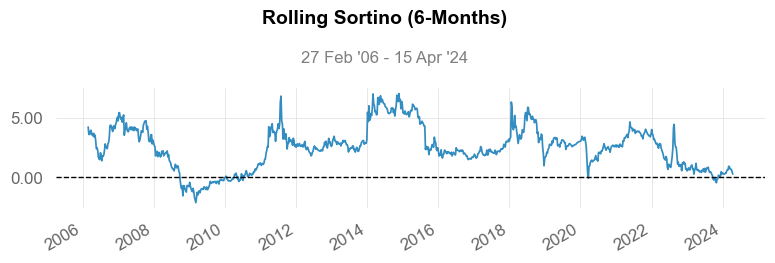

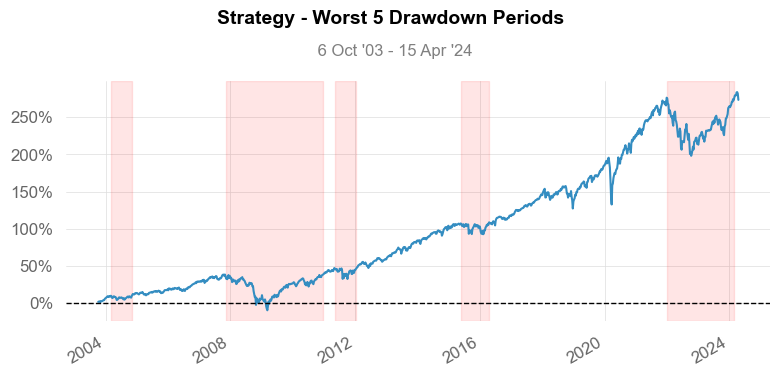

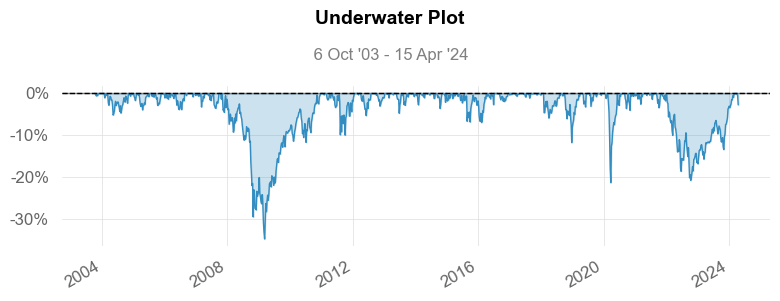

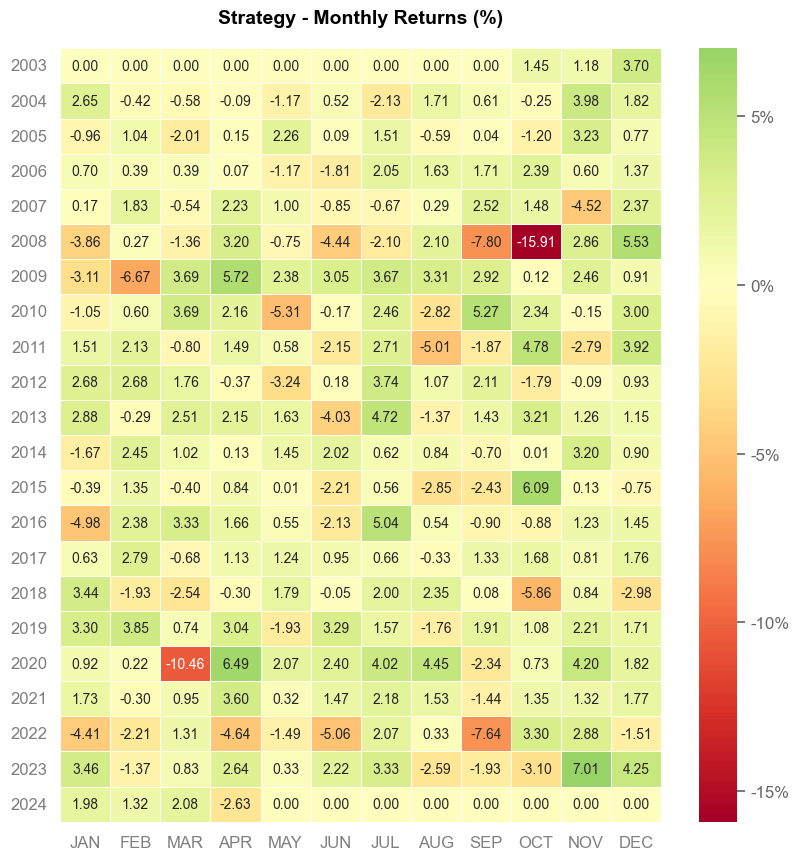

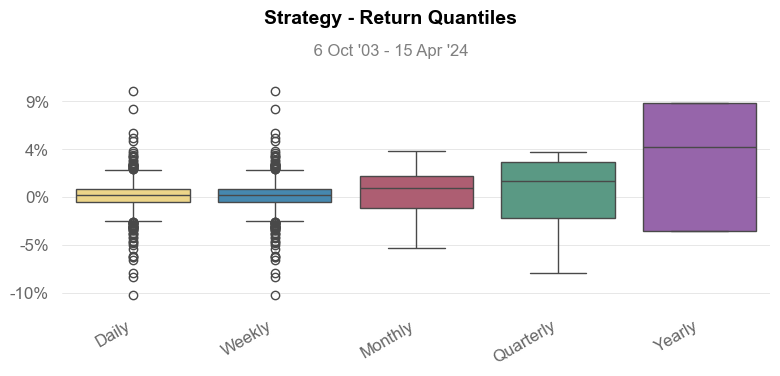

In [ ]:
#%%

qs.reports.full(portfolio_df['adjusted_ret'])